In [ ]:
# mount the google drive - this is necessary to access supporting src
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
! pip install pgmpy

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/bmin5200-2023/src")
from util import directed_graph_from_list, draw_graph

This cell illustrates the Bayesian network model constructed in the following cell using pgmpy

Notice that the edges are directed

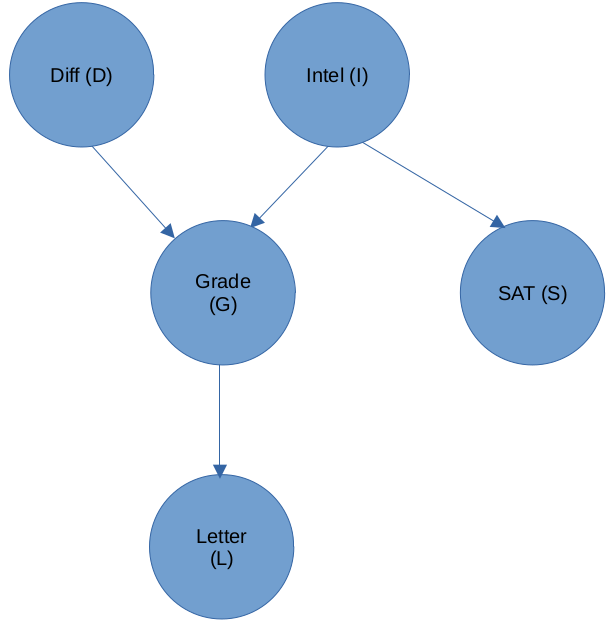

In [ ]:
# This cell implements the above Bayesian network using pgmpy

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianNetwork([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['easy', 'hard']})
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['no', 'yes']})

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | intel   | no      | no      | yes     | yes     |
#    +---------+---------+---------+---------+---------+
#    | diff    | easy    | hard    | easy    | hard    |
#    +---------+---------+---------+---------+---------+
#    | grade A | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade B | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade C | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3,
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2],
                  state_names={'G': ['A', 'B', 'C'],
                               'D': ['easy', 'hard'],
                               'I': ['no', 'yes']})

cpd_l = TabularCPD(variable='L', variable_card=2,
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3],
                   state_names={'L': ['bad', 'good'],
                                'G': ['A', 'B', 'C']})

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2],
                   state_names={'S': ['low', 'high'],
                                'I': ['no', 'yes']})

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()

In [ ]:
# with the model created, we can examine independencies in the model
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

In [ ]:
# we can also infer probabilities from the model
# here we will use variable elimination
infer = VariableElimination(model)

# First let's infer the marginal probability of grade
g_dist = infer.query(['G'])
print(g_dist)


In [ ]:
# Now let's infer intelligence given grade of C
i_dist = infer.query(['I'], evidence={'G': 'C'})
print(i_dist)

In [ ]:
# what happens if we also observe that the difficulty is hard?
i_dist = infer.query(['I'], evidence={'G': 'C', 'D': 'hard'})
print(i_dist)

In [ ]:
# what happens if we observe that the difficulty is hard and SAT is high?
i_dist = infer.query(['I'], evidence={'G': 'C', 'D': 'hard', 'S': 'high'})
print(i_dist)